<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_2/Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024



# **Taller 2**

GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.

1.  Exploración y Preparación de Datos

    -   Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.

2.  Implementación de Gradient Boosting

    -   Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?

3. Implementación de un nuevo metodo Ensemble
    - Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.
    - Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.

4.  Optimización y Ajuste

    -   Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).

Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)


## 1. Exploración y Preparación de Datos

In [1]:
# Descargar dataset
import requests
from zipfile import ZipFile
from io import BytesIO

url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

response = requests.get(url)
zip_content = response.content
with ZipFile(BytesIO(zip_content)) as zip_file:
    zip_file.extractall("./EuroSAT")

In [2]:
# Carga de imágenes
import os
import cv2
import numpy as np

def load_image(folder):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            #image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

X, y = load_image('./EuroSAT')

(3750, 64, 64, 3)
(3750,)
0
['Forest' 'Industrial' 'PermanentCrop' 'Residential' 'River']


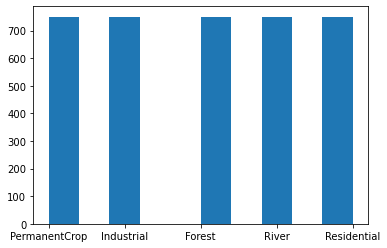

In [3]:
# Exploración de datos
import matplotlib.pyplot as plt

print(X.shape) # 3750 imágenes de 64 x 64 pixéles y las dimensiones de RGB (3)
print(y.shape) # Las etiquetas correspondientes
print(np.isnan(X).sum()) # Los datos están completos
print(np.unique(y)) # Las imágenes están clasificadas en 5 categorías
plt.hist(y) # Las categorías están balanceadas y presentan una distribución uniforme
plt.show()

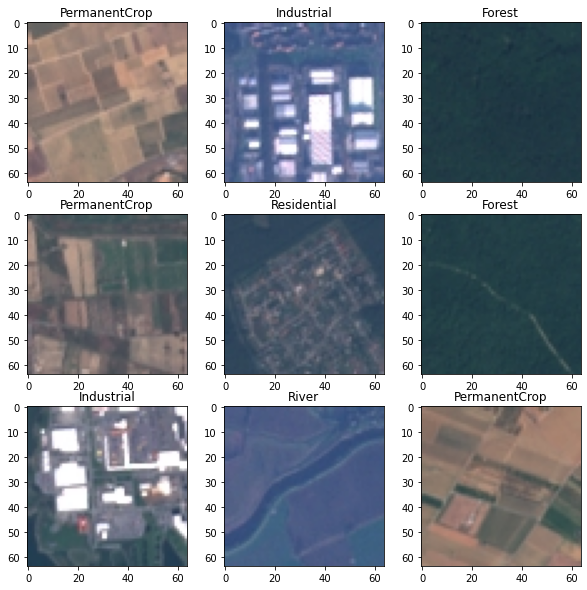

In [4]:
np.random.seed(24) # Para hacer los resultados reproducibles

# Observar las imágenes
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(X))
    plt.imshow(X[rdn])
    plt.title(y[rdn])

In [5]:
# Preprocesamiento de datos

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 80% de los datos serán de entrenamiento. No es necesario estratificar porque los datos son balanceados
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape)

# Transformador para pasar de 3D (64x64x3) a 1D (12288)
# Lo utilizamos porque el modelo de Gradient Boosting tiene como input un vector de carácteristicas para 
# cada observación. En contraste a una red convolusional que si maneja la matriz como tal.
flatenner = FunctionTransformer(lambda m: m.reshape(m.shape[0], -1))

# Pipeline para hacer el preprocesamiento de datos robusto y reproducible
# Usamos StandardScaler para mejorar el resultado de PCA, ya que es sensible a la escala de los datos
# Usamos PCA para reducir la dimensionalidad (menor a 12288) explicando el 95% de la varianza observada
# Mejorando el tiempo de entrenamiento del modelo 
pipeline = Pipeline([
    ('flatenner', flatenner),
    ('standardscaler', StandardScaler()),
    ('pca', PCA(0.95))
])
pipeline

(3000, 64, 64, 3) (750, 64, 64, 3)


Pipeline(steps=[('flatenner',
                 FunctionTransformer(func=<function <lambda> at 0x7f5e411add80>)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95))])

## Implementación de Gradient Boosting